In [1]:
import os
import math

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, f_classif, VarianceThreshold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import xgboost as xgb
np.random.seed(42)

In [2]:
data_path = os.path.abspath("/home/angelie/Documents/AdaLab/pharmaimage/data/yeo_Y/z/median/uni_clip_0.9999/multi_clip_N") # use iterative imputation

In [3]:
df = np.load(os.path.join(data_path, 'df.pkl'), allow_pickle=True)

In [4]:
blood_names = np.load(os.path.join(data_path, 'blood_names.npy'), allow_pickle=True)
clinical_names = np.load(os.path.join(data_path, 'clinical_names.npy'), allow_pickle=True)
imaging_names = np.load(os.path.join(data_path, 'imaging_names.npy'), allow_pickle=True)
missing_feat_names = np.load(os.path.join(data_path, 'missing_feat_names.npy'), allow_pickle=True)
static_names = np.load(os.path.join(data_path, 'static_names.npy'), allow_pickle=True)

In [5]:
df

,blood_T1_Proinsulinintakt,blood_T1_oxLDL,blood_T1_Nitrotyrosin,blood_T1_S100A12_plasma,blood_T1_Calprotectinn,blood_T1_Zonulin_N1200,blood_T1_hArginin,blood_T1_SDMA,blood_T1_KNYAcid,blood_T1_NTproBNP_MissingRepl,...,clinical_diabetes_any_nan,clinical_localisation_ThrAbdPlv_nan,clinical_MNA_mal_nan,clinical_MNA_normal_nan,clinical_MNA_risk_nan,clinical_anaesth_type_combined_nan,clinical_anaesth_type_general_nan,clinical_anaesth_type_regional_nan,POD,POCD
0,-0.003451,-0.004083,-0.03756,0.02467,0.029969,-0.086108,0.05213,-0.005613,0.010919,-0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.003451,-0.004083,-0.03756,0.02467,0.029969,-0.086108,0.05213,-0.005613,0.010919,-0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.003451,-0.004083,-0.03756,0.02467,0.029969,-0.086108,0.05213,-0.005613,0.010919,-0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,-0.003451,-0.004083,-0.03756,0.02467,0.029969,-0.086108,0.05213,-0.005613,0.010919,-0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.003451,-0.004083,-0.03756,0.02467,0.029969,-0.086108,0.05213,-0.005613,0.010919,-0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,-0.003451,-0.004083,-0.03756,0.02467,0.029969,-0.777939,0.05213,-0.005613,0.010919,-0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
929,-0.003451,-0.004083,-0.03756,0.02467,0.029969,-1.558332,0.05213,-0.005613,0.010919,-0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
930,-0.003451,-0.004083,-0.03756,0.02467,0.029969,-0.395685,0.05213,-0.005613,0.010919,-0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
931,-0.003451,-0.004083,-0.03756,0.02467,0.029969,-1.329304,0.05213,-0.005613,0.010919,-0.139004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
df.loc[df['brain_imaging_regions_nan']==0, imaging_names]

,brain_lh_Pole_occipital_thickness,brain_Rightchoroidplexus,brain_lh_GS_cingulMidAnt_volume,brain_rh_Pole_occipital_area,brain_lh_paracentral_area,brain_rh_G_octemp_latfusifor_volume,brain_rh_superiortemporal_meancurv,brain_middletemporal_area,brain_rh_S_suborbital_meancurv,brain_lh_S_circular_insula_sup_area,...,brain_rh_GS_cingulAnt_area,brain_lh_G_temp_supPlan_tempo_thickness,brain_rh_S_circular_insula_ant_meancurv,brain_rh_GS_cingulMidPost_thickness,brain_rh_superiorparietal_meancurv,brain_lh_S_orbitalH_Shaped_meancurv,brain_lh_G_pariet_infAngular_thickness,brain_rh_paracentral_thickness,brain_rh_S_interm_primJensen_area,brain_Leftchoroidplexus
0,-1.299121,1.137055,-0.002863,-0.667461,0.203754,0.412556,-0.797585,0.794933,-1.150401,0.732899,...,-0.689900,-0.051939,1.649432,0.506944,1.979041,0.481703,-1.041434,0.184151,0.160230,0.196258
1,-0.233560,2.784536,-1.538087,-1.182695,-0.682614,0.097645,1.074247,0.499231,-1.294970,0.401506,...,1.466544,-1.924424,0.710975,-1.301807,1.979041,-0.469454,-0.565860,-1.522595,-1.231988,2.813286
2,-1.307162,0.803323,-0.544390,0.927085,-2.855905,0.414994,-1.428322,-0.567923,1.466017,0.861928,...,-1.302673,-0.020196,-0.609555,-2.449671,0.129510,-1.601674,0.015996,-1.901817,-0.824635,0.834052
3,0.793610,-0.634606,1.892528,0.772154,0.155156,-0.949866,-0.295459,0.574625,-2.492514,0.416511,...,1.076249,-1.672034,0.579262,0.275818,2.694411,0.290916,-0.034535,-1.326479,-0.660740,-0.256443
4,-0.052495,-0.954663,2.152257,0.473310,0.038793,-0.125423,-0.295459,1.402456,0.649892,0.550385,...,0.422140,1.121209,0.305210,0.696500,1.347034,-0.942429,-0.097717,1.510682,1.029244,-0.419435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,-1.619912,-0.186848,-0.176087,0.065950,-0.401920,-0.977277,-0.797585,-1.668195,-0.231185,0.594546,...,-0.723327,-0.178768,0.710975,0.441698,-0.204001,0.768403,-0.028218,0.730574,-1.393856,-0.984982
917,1.333503,-1.732256,0.517992,0.087518,-0.280369,0.445383,0.079710,-1.035851,-0.311274,-0.534053,...,0.018706,-0.220993,1.432809,-0.576502,-1.032098,0.672767,0.564735,1.379041,-0.112295,-2.226511
922,-0.744259,-0.653758,-0.573968,0.271309,0.057256,-0.370599,0.578049,-0.272394,-2.048330,0.119033,...,-0.839571,-0.336980,0.162668,-0.030987,0.019709,0.959883,-1.327323,-0.667504,-0.248936,-1.156242
923,-0.483685,-0.953248,-0.743764,-0.113094,-0.735723,-0.857888,-0.295459,-0.890402,-1.294970,-1.982021,...,-0.946074,-0.036069,0.775547,-0.165176,-0.204001,-0.089824,0.841719,-0.418336,0.455197,-0.791684


In [7]:
df.loc[df['brain_imaging_cubic_vol_nan']==0, imaging_names]

,brain_lh_Pole_occipital_thickness,brain_Rightchoroidplexus,brain_lh_GS_cingulMidAnt_volume,brain_rh_Pole_occipital_area,brain_lh_paracentral_area,brain_rh_G_octemp_latfusifor_volume,brain_rh_superiortemporal_meancurv,brain_middletemporal_area,brain_rh_S_suborbital_meancurv,brain_lh_S_circular_insula_sup_area,...,brain_rh_GS_cingulAnt_area,brain_lh_G_temp_supPlan_tempo_thickness,brain_rh_S_circular_insula_ant_meancurv,brain_rh_GS_cingulMidPost_thickness,brain_rh_superiorparietal_meancurv,brain_lh_S_orbitalH_Shaped_meancurv,brain_lh_G_pariet_infAngular_thickness,brain_rh_paracentral_thickness,brain_rh_S_interm_primJensen_area,brain_Leftchoroidplexus
0,-1.299121,1.137055,-0.002863,-0.667461,0.203754,0.412556,-0.797585,0.794933,-1.150401,0.732899,...,-0.689900,-0.051939,1.649432,0.506944,1.979041,0.481703,-1.041434,0.184151,0.160230,0.196258
1,-0.233560,2.784536,-1.538087,-1.182695,-0.682614,0.097645,1.074247,0.499231,-1.294970,0.401506,...,1.466544,-1.924424,0.710975,-1.301807,1.979041,-0.469454,-0.565860,-1.522595,-1.231988,2.813286
2,-1.307162,0.803323,-0.544390,0.927085,-2.855905,0.414994,-1.428322,-0.567923,1.466017,0.861928,...,-1.302673,-0.020196,-0.609555,-2.449671,0.129510,-1.601674,0.015996,-1.901817,-0.824635,0.834052
3,0.793610,-0.634606,1.892528,0.772154,0.155156,-0.949866,-0.295459,0.574625,-2.492514,0.416511,...,1.076249,-1.672034,0.579262,0.275818,2.694411,0.290916,-0.034535,-1.326479,-0.660740,-0.256443
4,-0.052495,-0.954663,2.152257,0.473310,0.038793,-0.125423,-0.295459,1.402456,0.649892,0.550385,...,0.422140,1.121209,0.305210,0.696500,1.347034,-0.942429,-0.097717,1.510682,1.029244,-0.419435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,-0.781308,0.205110,-1.066978,0.162411,-0.401920,0.933120,-0.546250,-0.312097,0.915510,-0.517311,...,-0.667693,0.660376,-0.948402,-0.707237,-0.668377,-0.374651,-0.243106,0.747553,0.251209,0.648481
917,1.333503,-1.732256,0.517992,0.087518,-0.280369,0.445383,0.079710,-1.035851,-0.311274,-0.534053,...,0.018706,-0.220993,1.432809,-0.576502,-1.032098,0.672767,0.564735,1.379041,-0.112295,-2.226511
922,-0.744259,-0.653758,-0.573968,0.271309,0.057256,-0.370599,0.578049,-0.272394,-2.048330,0.119033,...,-0.839571,-0.336980,0.162668,-0.030987,0.019709,0.959883,-1.327323,-0.667504,-0.248936,-1.156242
923,-0.483685,-0.953248,-0.743764,-0.113094,-0.735723,-0.857888,-0.295459,-0.890402,-1.294970,-1.982021,...,-0.946074,-0.036069,0.775547,-0.165176,-0.204001,-0.089824,0.841719,-0.418336,0.455197,-0.791684


In [8]:
imaging_missings = [col for col in missing_feat_names if col.startswith('brain_')]
df[imaging_missings]

,brain_imaging_regions_nan,brain_imaging_cubic_vol_nan
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
928,1.0,1.0
929,1.0,1.0
930,1.0,1.0
931,1.0,1.0


In [26]:
#all_df = pd.concat([df[imaging_names], df[clinical_names], df[blood_names], df[missing_feat_names], df[static_names], df['POD']], axis=1)
all_df = pd.concat([df[imaging_names], df[clinical_names], df[static_names], df[blood_names], df['POD']], axis=1)
#imaging_df = pd.concat([df[imaging_names], df[clinical_names], df['POD']], axis=1)
#imaging_df = imaging_df.loc[df['brain_imaging_regions_nan']==1, :]
all_df

,brain_lh_Pole_occipital_thickness,brain_Rightchoroidplexus,brain_lh_GS_cingulMidAnt_volume,brain_rh_Pole_occipital_area,brain_lh_paracentral_area,brain_rh_G_octemp_latfusifor_volume,brain_rh_superiortemporal_meancurv,brain_middletemporal_area,brain_rh_S_suborbital_meancurv,brain_lh_S_circular_insula_sup_area,...,blood_T1_Leptin_Adipon_Ratio,blood_T1_SORL1,blood_T1_IL2_pgml,blood_T1_IL8_pgml,blood_T1_IL10_pgml,blood_T1_IL18_pgml,blood_T1_Volk_IL8_pgml,blood_T1_IL18_pgml_Boraschi,blood_Final_T1_TP42_40,POD
0,-1.299121,1.137055,-0.002863,-0.667461,0.203754,0.412556,-0.797585,0.794933,-1.150401,0.732899,...,-0.072813,0.060185,-0.105497,-0.131936,-0.233885,0.012586,-0.287939,-0.174007,-0.018390,0.0
1,-0.233560,2.784536,-1.538087,-1.182695,-0.682614,0.097645,1.074247,0.499231,-1.294970,0.401506,...,-0.072813,0.060185,-0.105497,-0.131936,-0.233885,0.012586,-0.287939,-0.174007,-0.018390,0.0
2,-1.307162,0.803323,-0.544390,0.927085,-2.855905,0.414994,-1.428322,-0.567923,1.466017,0.861928,...,-0.072813,0.060185,-0.105497,-0.131936,-0.233885,0.012586,-0.287939,-0.174007,-0.018390,1.0
3,0.793610,-0.634606,1.892528,0.772154,0.155156,-0.949866,-0.295459,0.574625,-2.492514,0.416511,...,-0.072813,0.060185,-0.105497,-0.131936,-0.233885,0.012586,-0.287939,-0.174007,-0.018390,0.0
4,-0.052495,-0.954663,2.152257,0.473310,0.038793,-0.125423,-0.295459,1.402456,0.649892,0.550385,...,-0.072813,0.060185,-0.105497,-0.131936,-0.233885,0.012586,-0.287939,-0.174007,-0.018390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,-0.022844,0.032730,-0.002863,0.009878,-0.066472,0.035828,-0.045211,-0.058922,0.013007,-0.021843,...,1.326354,0.329503,-0.105497,-0.526285,-0.233885,0.162305,-0.287939,-0.174007,-1.734236,0.0
929,-0.022844,0.032730,-0.002863,0.009878,-0.066472,0.035828,-0.045211,-0.058922,0.013007,-0.021843,...,-0.696991,-0.213660,0.382805,-0.131936,-0.233885,0.399490,-0.287939,-0.174007,-1.832048,0.0
930,-0.022844,0.032730,-0.002863,0.009878,-0.066472,0.035828,-0.045211,-0.058922,0.013007,-0.021843,...,-1.251085,1.992027,0.109548,-0.131936,-0.233885,-0.954567,-0.287939,-0.174007,0.446011,0.0
931,-0.022844,0.032730,-0.002863,0.009878,-0.066472,0.035828,-0.045211,-0.058922,0.013007,-0.021843,...,-1.775257,1.465710,-0.105497,-0.131936,-0.233885,-1.258537,-0.287939,-0.174007,-0.481065,0.0


<AxesSubplot:>

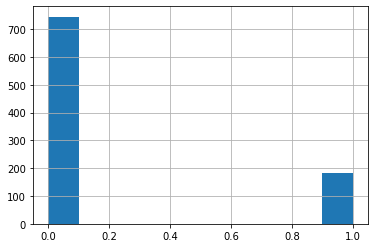

In [10]:
all_df['POD'].hist()

In [11]:
all_df['POD'].mean()

0.19806243272335844

# Univariate stuff
https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

In [10]:
def fit_xgb(X_train, Y_train):
    model = xgb.XGBClassifier(n_estimators=1000,
                                  max_depth=10,
                                  learning_rate=0.1)
    model.fit(X_train, Y_train)
    return model


In [11]:
def fit_rf(X_train, Y_train):
    model = RandomForestClassifier(n_estimators=10000)
    model.fit(X_train, Y_train)
    return model

In [12]:
def run_train(X_dev, Y_dev, indcs):
    acc_scores, auc_scores = [], []
    models = []
    
    for train_index, val_index in indcs:
        model = fit_xgb(X_dev.iloc[train_index], Y_dev.iloc[train_index])
        Y_pred = model.predict(X_dev.iloc[val_index])
        acc_scores.append(accuracy_score(Y_pred, Y_dev.iloc[val_index]))
        auc_scores.append(roc_auc_score(Y_pred, Y_dev.iloc[val_index]))
        models.append(model)
    print(f"Mean accuracy over {len(indcs)} folds is {np.mean(acc_scores)}")
    print(f"Mean AUC over {len(indcs)} folds is {np.mean(auc_scores)}")

    best_model_idx = np.where(auc_scores == np.amax(auc_scores))[0][0]
    return models[best_model_idx]


In [27]:
# Select data
X = all_df.loc[:, all_df.columns != 'POD']
Y = all_df.loc[:, 'POD']
X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [28]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=42)
folds_indcs = [(train_index, val_index) for (train_index, val_index) in skf.split(X_dev, Y_dev)]

In [29]:
# Before reduction
run_train(X_dev, Y_dev, folds_indcs)

Mean accuracy over 5 folds is 0.8349372683205019
Mean AUC over 5 folds is 0.7528667812035361


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## RFECV

In [30]:
from sklearn.feature_selection import RFECV

In [31]:
model = xgb.XGBClassifier(n_estimators=1000,
                                  max_depth=10,
                                  learning_rate=0.1)

In [32]:
rfecv = RFECV(estimator=model, step=0.1, cv=StratifiedKFold(3, random_state=42),
              scoring='roc_auc', verbose=1, n_jobs=-1) 
rfecv.fit(X_dev, Y_dev)

print("Optimal number of features : %d" % rfecv.n_features_)


Fitting estimator with 1219 features.
Fitting estimator with 1098 features.
Fitting estimator with 977 features.
Fitting estimator with 856 features.
Fitting estimator with 735 features.
Fitting estimator with 614 features.
Fitting estimator with 493 features.
Optimal number of features : 372


In [33]:
selected_cols = [X_dev.columns[i] for i, indicator in enumerate(rfecv.support_) if indicator == True]
print(selected_cols)

['brain_Rightchoroidplexus', 'brain_lh_GS_cingulMidAnt_volume', 'brain_rh_superiortemporal_meancurv', 'brain_middletemporal_area', 'brain_rh_S_oc_suptransversal_thickness', 'brain_lh_G_front_infOrbital_volume', 'brain_lh_S_suborbital_area', 'brain_lh_S_circular_insula_ant_meancurv', 'brain_rh_S_front_middle_area', 'brain_rh_S_subparietal_volume', 'brain_lh_GS_frontomargin_thickness', 'brain_rh_G_temporal_middle_volume', 'brain_lh_posteriorcingulate_thickness', 'brain_superiorfrontal_meancurv', 'brain_pericalcarine_meancurv', 'brain_lh_Lat_FisantVertical_area', 'brain_rh_S_circular_insula_sup_area', 'brain_lh_S_suborbital_volume', 'brain_rh_S_central_meancurv', 'brain_lh_fusiform_thickness', 'brain_lh_S_front_middle_meancurv', 'brain_rh_G_precuneus_meancurv', 'brain_rh_rostralanteriorcingulate_thickness', 'brain_lh_S_intraparietP_trans_area', 'brain_lh_lateraloccipital_thickness', 'brain_lh_middletemporal_thickness', 'brain_rh_GS_subcentral_meancurv', 'brain_rh_G_front_sup_meancurv', 'b

In [34]:
run_train(X_dev.loc[:, selected_cols], Y_dev, folds_indcs)

Mean accuracy over 5 folds is 0.8313515825491873
Mean AUC over 5 folds is 0.7452537419348564


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
cols_w_rank = zip(df.columns, rfecv.ranking_)
sorted_cols_w_rank = sorted(cols_w_rank, key=lambda tup: tup[1])
sorted_cols = [col[0] for col in sorted_cols_w_rank]

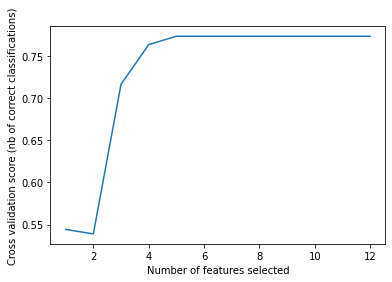

In [36]:

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

## Variance threshold

But: https://datascience.stackexchange.com/questions/31453/how-to-decide-what-threshold-to-use-for-removing-low-variance-features

In [ ]:
thresh = (.999 * (1 - .999))
sel = VarianceThreshold(threshold=thresh)
X_dev_sel = sel.fit_transform(X_dev)
print(f"removed {X_dev.shape[1] - X_dev_sel.shape[1]} features")

In [ ]:
feat_variances = pd.DataFrame(sel.variances_, index=X_dev.columns)
feat_variances

In [ ]:
feat_variances = feat_variances.sort_values(by=0)
dropped_feats = feat_variances[feat_variances < thresh].dropna() 
dropped_feats

In [ ]:
# After reduction
run_train(pd.DataFrame(X_dev_sel), Y_dev, folds_indcs)

## Univariate tests

In [ ]:
univariate_transformer = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=50)
univariate_transformer.fit(X_dev, Y_dev)
X_dev_transformed = univariate_transformer.transform(X_dev)
#X_test_transformed = univariate_transformer.transform(X_test)

In [ ]:
X_dev_transformed.shape

In [ ]:
# After reduction
run_train(pd.DataFrame(X_dev_transformed), Y_dev, folds_indcs)

## PCA

In [18]:
# indices for cases that come with all image data
imaging_dev_idcs = X_dev['brain_imaging_regions_nan']==0
imaging_test_idcs = X_test['brain_imaging_regions_nan']==0

# from the dev and test splits (created earlier) take only the imaging related data
imaging_X_dev = X_dev.loc[imaging_dev_idcs, imaging_names]#, Y_dev[imaging_dev_idcs]
imaging_X_test = X_test.loc[imaging_test_idcs, imaging_names]#, Y_test[imaging_test_idcs]

# put all the remaining data into separate data frames
non_imaging_df = pd.concat([df[clinical_names], df[blood_names], df[missing_feat_names], df[static_names]], axis=1)
non_imaging_X_dev = non_imaging_df.loc[X_dev.index, :]
non_imaging_X_test = non_imaging_df.loc[X_test.index, :]


In [19]:
imaging_X_dev

,brain_lh_Pole_occipital_thickness,brain_Rightchoroidplexus,brain_lh_GS_cingulMidAnt_volume,brain_rh_Pole_occipital_area,brain_lh_paracentral_area,brain_rh_G_octemp_latfusifor_volume,brain_rh_superiortemporal_meancurv,brain_middletemporal_area,brain_rh_S_suborbital_meancurv,brain_lh_S_circular_insula_sup_area,...,brain_rh_GS_cingulAnt_area,brain_lh_G_temp_supPlan_tempo_thickness,brain_rh_S_circular_insula_ant_meancurv,brain_rh_GS_cingulMidPost_thickness,brain_rh_superiorparietal_meancurv,brain_lh_S_orbitalH_Shaped_meancurv,brain_lh_G_pariet_infAngular_thickness,brain_rh_paracentral_thickness,brain_rh_S_interm_primJensen_area,brain_Leftchoroidplexus
60,1.539244,-0.374416,-0.472562,-0.263226,-1.178186,0.566695,-0.170267,0.138149,-0.311274,1.936450,...,0.562881,0.244887,-0.527632,0.369424,0.345092,0.100407,0.173826,-1.522595,0.736285,-1.518372
427,-0.871104,-0.766456,-0.593750,-2.299541,-1.332582,-0.978804,-1.049468,-0.405845,-0.469512,-2.101892,...,-1.613738,1.067479,-0.288309,0.111176,0.960923,2.017976,0.463925,0.476461,-0.693065,-0.706165
518,-0.455388,0.956384,-0.459574,-0.546986,-0.254966,0.194289,0.204496,-0.734243,0.013007,-0.771936,...,-0.513979,0.906515,-1.979670,-0.347438,-0.909348,-1.036816,0.047571,0.341371,-1.183438,0.744460
700,-0.962158,0.535269,0.454726,-0.877745,-0.623204,-1.046354,-0.420786,-0.049571,0.347916,-0.157062,...,-1.057939,1.779763,0.375083,0.427224,-0.788114,-0.184836,1.683086,0.116898,-0.703889,0.412097
66,-0.019558,-1.052315,0.088384,-0.483672,-0.930675,-0.315574,-0.420786,-1.265153,-0.231185,-0.875945,...,0.039023,0.128129,-0.446794,-0.528124,0.345092,1.343674,-0.724260,-1.755879,0.104935,-0.721341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.167925,0.402469,-1.126931,0.169496,1.234678,-0.578580,1.074247,1.224787,0.649892,1.169334,...,0.321509,-0.426472,-0.609555,-0.249492,1.533134,1.055727,-1.384550,-1.620378,-0.714738,0.568473
107,1.235193,0.313278,-0.531280,-0.195213,-0.427700,-1.250486,-1.554883,-1.215220,-1.401831,-0.133044,...,0.186479,-0.009611,-0.446794,0.725804,0.345092,-1.695574,1.269085,0.493369,-1.064449,-0.037043
274,-0.619872,0.154014,0.906559,2.756471,2.237341,2.181981,1.445000,2.361017,-0.625193,1.345893,...,2.123801,0.244887,-0.609555,1.125070,0.019709,0.481703,0.205378,1.436243,1.888594,1.270882
864,1.318107,0.125185,0.437385,0.989179,0.543433,0.289469,1.691509,0.468910,-1.040391,1.128064,...,-1.254694,-0.730916,0.964260,0.004466,0.345092,0.481703,0.085456,-0.385029,0.884428,0.413542


In [20]:
# create PCA embeddings for only the imaging data
keep_variance = .99
pca_imaging = PCA(keep_variance)

pca_imaging.fit(imaging_X_dev)
X_train_pca_embedding_img = pca_imaging.transform(imaging_X_dev)
X_test_pca_embedding_img = pca_imaging.transform(imaging_X_test)

In [21]:
print(f"PCA created {len(pca_imaging.components_)} components for the imaging data to preserve {keep_variance * 100} % variance")

PCA created 333 components for the imaging data to preserve 99.0 % variance


In [22]:
pca_imaging.explained_variance_ratio_.sum()


0.9900808727451571

In [23]:
# create PCA embeddings for only the non-imaging data
pca_non_imaging = PCA(keep_variance)

pca_non_imaging.fit(non_imaging_X_dev)
X_train_pca_embedding_non_img = pca_non_imaging.transform(non_imaging_X_dev)
X_test_pca_embedding_non_img = pca_non_imaging.transform(non_imaging_X_test)

In [24]:
print(f"PCA created {len(pca_non_imaging.components_)} components for the non-imaging data to preserve {keep_variance * 100} % variance")

PCA created 130 components for the non-imaging data to preserve 99.0 % variance


In [33]:
len(df.columns) - len(imaging_names)

272

In [25]:
X_train_pca_embedding_non_img

array([[ 4.27239663,  0.10634246, -0.13282044, ..., -0.11966609,
        -0.01935941,  0.02197043],
       [-2.82388566,  3.24734145,  2.16667069, ..., -0.10455753,
        -0.22023244, -0.02950829],
       [ 0.85255826, -0.04650894, -1.99427781, ..., -0.86049947,
         0.32925562, -0.16178849],
       ...,
       [ 0.09530574, -2.59557913, -0.69482145, ...,  0.3835604 ,
         0.19494273,  0.2421154 ],
       [-2.6307747 ,  1.39353209, -2.23850899, ..., -0.01847253,
         0.20844528, -0.21303641],
       [ 4.78259881,  0.31120964, -0.20620783, ...,  0.06838571,
        -0.2161269 ,  0.0224328 ]])

In [26]:
# Merge the imaging and non-imaging related embedded data
# fill all cases where there was originally no imaging data with medians of the values from the newly created embedding
X_dev_pca_embedding_concat = pd.concat([pd.DataFrame(X_train_pca_embedding_img).add_prefix('img'), pd.DataFrame(X_train_pca_embedding_non_img).add_prefix('non_img')], axis=1)
X_dev_pca_embedding_concat = X_dev_pca_embedding_concat.fillna(X_dev_pca_embedding_concat.median())

In [27]:
X_dev_pca_embedding_concat

,img0,img1,img2,img3,img4,img5,img6,img7,img8,img9,...,non_img120,non_img121,non_img122,non_img123,non_img124,non_img125,non_img126,non_img127,non_img128,non_img129
0,-6.094537,-0.983051,-8.491791,-0.580337,-6.139542,6.945370,-0.952466,0.247247,1.706507,-4.059223,...,-0.140050,0.135980,-0.133206,-0.242470,0.262046,-0.149628,0.352965,-0.119666,-0.019359,0.021970
1,18.356806,-8.807269,-4.398985,-3.233303,4.576847,3.289941,-5.875206,-1.466069,1.862772,1.095599,...,0.108389,-0.026742,0.246495,0.271118,-0.166939,-0.412156,-0.087127,-0.104558,-0.220232,-0.029508
2,9.514421,0.560154,10.121122,8.096299,5.593362,-5.108226,2.970522,-1.611722,1.614120,2.850751,...,-0.042951,0.499070,-0.272958,-0.093263,0.085428,0.235755,0.172011,-0.860499,0.329256,-0.161788
3,9.311695,-13.771919,-4.844908,-4.082733,3.673129,3.026900,1.842109,-5.864473,-0.014238,-0.739582,...,-0.787855,-0.042836,0.117293,-0.015347,0.060572,-0.107178,-0.042635,0.019954,0.158044,-0.321720
4,6.881458,0.804666,-6.259146,-6.411789,-9.276757,1.905473,1.526727,-3.819876,-5.360667,-3.477125,...,-0.344208,0.620306,0.208512,0.382178,-0.161628,-0.177446,-0.235978,-0.455673,0.103362,-0.071463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,0.676384,0.019284,0.148250,0.114826,-0.093838,0.213259,-0.045291,-0.121271,0.234558,-0.028000,...,0.225889,-0.229518,-0.176741,0.005562,0.462782,0.418066,-0.023707,-0.454863,-0.149823,0.678804
832,0.676384,0.019284,0.148250,0.114826,-0.093838,0.213259,-0.045291,-0.121271,0.234558,-0.028000,...,-0.262446,-0.103295,-0.012676,0.171458,-0.007507,-0.038576,0.215753,0.218966,-0.099749,0.294776
833,0.676384,0.019284,0.148250,0.114826,-0.093838,0.213259,-0.045291,-0.121271,0.234558,-0.028000,...,-0.499132,-0.118342,-0.355147,-0.448501,0.373160,0.157331,0.396310,0.383560,0.194943,0.242115
834,0.676384,0.019284,0.148250,0.114826,-0.093838,0.213259,-0.045291,-0.121271,0.234558,-0.028000,...,0.009150,-0.203532,-0.259589,0.268215,-0.076716,0.289293,0.132745,-0.018473,0.208445,-0.213036


In [28]:
# Train on combined embeddings and new nan-fillings
model = run_train(pd.DataFrame(X_dev_pca_embedding_concat), Y_dev, folds_indcs)

Mean accuracy over 5 folds is 0.8026375819788992
Mean AUC over 5 folds is 0.6653132283433916


In [29]:
X_test_pca_embedding_concat = pd.concat([pd.DataFrame(X_test_pca_embedding_img).add_prefix('img'), pd.DataFrame(X_test_pca_embedding_non_img).add_prefix('non_img')], axis=1)
X_test_pca_embedding_concat = X_test_pca_embedding_concat.fillna(X_test_pca_embedding_concat.median())

In [30]:
Y_pred = model.predict(X_test_pca_embedding_concat)
print("accuracy", accuracy_score(Y_pred, Y_test))
print("auc", roc_auc_score(Y_pred, Y_test))

accuracy 0.7741935483870968
auc 0.5611111111111111


In [31]:
len(Y_test)

93

# Autoencoder

In [ ]:
!pip install keras
from keras.layers import Input, Dense
from keras.models import Model


In [ ]:
X = df[imaging_names]

In [ ]:
input_layer = Input(shape=(X.shape[1],))
encoded = Dense(3, activation='relu')(input_layer)
decoded = Dense(X.shape[1], activation='softmax')(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

autoencoder.fit(X_train, Y_train,
                epochs=100,
                batch_size=300,
                shuffle=True,
                verbose = 30,
                validation_data=(X_test, Y_test))

encoder = Model(input_layer, encoded)
X_ae = encoder.predict(X)

In [ ]:
X_ae.shape

In [ ]:
X.shape

In [ ]:
import optuna
from sklearn.metrics import log_loss

# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    encoding_dim = trial.suggest_categorical('encoding_dim', np.arange(3, 300))
    input_layer = Input(shape=(X.shape[1],))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(X.shape[1], activation='softmax')(encoded)
    autoencoder = Model(input_layer, decoded)

    encoder = Model(input_layer, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder = Model(encoded_input, autoencoder.layers[-1](encoded_input))

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    X_train, X_test = train_test_split(X, test_size=0.3, random_state=101)

    autoencoder.fit(X_train, X_train,
                    epochs=100,
                    batch_size=300,
                    shuffle=True,
                    verbose = False,
                    validation_data=(X_test, X_test))

    # Compute the reconstruction loss
    
    encoder_embeddings = encoder.predict(X_test)
    X_pred = decoder.predict(encoder_embeddings)
    print(X_pred.shape, X_test.shape)

    mean_rec_loss = np.mean([log_loss(X_test[:, i], X_pred[:, i]) for i in range(X_test.shape[1])])
    return mean_rec_loss

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)